In [1]:
#### Import libraries ####
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from os import path
import matplotlib
import seaborn as sns
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
#### Font management ####
if not path.exists('Sarabun-Regular.ttf'):
    !wget https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf -O Sarabun-Regular.ttf
if 'Sarabun' not in [x.name for x in matplotlib.font_manager.fontManager.ttflist]:
    matplotlib.font_manager.fontManager.addfont('Sarabun-Regular.ttf')
matplotlib.rc('font', family='Sarabun')

In [3]:
#### Import Data ####

# Import shapefile from https://github.com/KittapatR/Thai-ECT-election-map-66/tree/main/ECT_constituencies/
map_df = gpd.read_file("shapefiles/2566_TH_ECT_attributes.shp")
map_df.rename(columns={'P_name':'จังหวัด', 'CONS_no':'เขต'}, inplace=True)

# Import election results
results_party_list = pd.read_excel('https://ectreport66.ect.go.th/data/excel/2566_election_result.xlsx', sheet_name='ผลคะแนนบัญชีรายชื่อ', skiprows = 3, converters={'เขต':int,'หมายเลข':int})
results_candidate = pd.read_excel('https://ectreport66.ect.go.th/data/excel/2566_election_result.xlsx', sheet_name='ผลคะแนนแบ่งเขต', skiprows = 3, converters={'เขต':int,'หมายเลขผู้สมัคร':int})
constituency_winners = pd.read_excel('https://www.ect.go.th/web-upload/1xff0d34e409a13ef56eea54c52a291126/m_document/2028/21360/file_download/14c269b6893553a8f697f16f32be2e59.xlsx', sheet_name = 'Reรายชื่อผู้ได้รับ แบ่งเขต', skiprows = 3)
party_list_winners = pd.read_excel('https://www.ect.go.th/web-upload/1xff0d34e409a13ef56eea54c52a291126/m_document/2028/21360/file_download/14c269b6893553a8f697f16f32be2e59.xlsx', sheet_name = 'Reผู้ได้รับเลือก บัญชี พรรค', skiprows = 10, converters={'รวม':int})[['Unnamed: 1', 'รวม']]

# Drop the last row (column sum)
results_party_list.drop(results_party_list.tail(1).index,inplace=True)
results_candidate.drop(results_candidate.tail(1).index,inplace=True)

# Cleaning
constituency_winners['จังหวัด'].ffill(inplace=True)
party_list_winners.drop(party_list_winners.tail(15).index,inplace=True)
party_list_winners.rename(columns = {'Unnamed: 1' : 'พรรค', 'รวม': 'total_party_list_seats'}, inplace = True)

In [4]:
#### Create a table reporting the election results by party ####

# Sum up the votes for each party from the party list results and reset the index for further manipulation.
party_list_votes = results_party_list.groupby('พรรค')['ผลคะแนน'].sum().reset_index()

# Sum up the votes for each party from the candidate results and reset the index for further manipulation.
constituency_votes = results_candidate.groupby('สังกัดพรรค')['คะแนน'].sum().reset_index()

# Rename columns in 'constituency_votes' for consistency and easier merging.
constituency_votes.rename(columns = {'สังกัดพรรค' : 'พรรค'}, inplace = True)

# Merge the two datasets on the 'พรรค' column to combine the results from party list and constituency votes.
merged_data = constituency_votes.merge(party_list_votes, on='พรรค')

# Rename columns for clarity.
merged_data.rename(columns = {'คะแนน' : 'mp_app_vote', 'ผลคะแนน': 'party_list_vote'}, inplace = True)

# Calculating Vote Shares
# Calculate the total votes across all parties for party list and constituency to use in vote share calculation.
total_party_list_vote = merged_data['party_list_vote'].sum()
total_constituency_vote = merged_data['mp_app_vote'].sum()

# Calculate vote share for each party in both the party list and constituency votes.
merged_data['party_list_vote_share'] = merged_data['party_list_vote'].apply(lambda x: x / total_party_list_vote)
merged_data['constituency_vote_share'] = merged_data['mp_app_vote'].apply(lambda x: x / total_constituency_vote)

# Calculate the difference between party list vote share and constituency vote share.
merged_data['difference'] = merged_data['party_list_vote_share'] - merged_data['constituency_vote_share']

# Merging Additional Data and Translating Party Names
# Group the constituency winners by party and count the number of seats won.
constituency_winners_party = constituency_winners.groupby('พรรค').count().reset_index()[['พรรค', 'รายชื่อผู้ได้รับเลือกตั้ง']]

# Merge the constituency winners with party list winners, filling missing values with zero, and then merge with the merged vote data.
filtered_data = constituency_winners_party.merge(party_list_winners, how='outer').fillna(0).merge(merged_data)

english_mapping = {
    'ก้าวไกล': 'Move Forward',
    'เพื่อไทย': 'Pheu Thai',
    'ภูมิใจไทย': 'Bhumjaithai',
    'พลังประชารัฐ': 'Palang Pracharath',
    'รวมไทยสร้างชาติ': 'United Thai Nation',
    'ประชาธิปัตย์': 'Democrat',
    'ชาติไทยพัฒนา': 'Chart Thai Pattana',
    'ประชาชาติ': 'Prachachart',
    'ไทยสร้างไทย': 'Thai Sang Thai',
    'ชาติพัฒนากล้า': 'Chart Pattana Kla',   
    'เพื่อไทรวมพลัง': 'Pheu Thai Ruam Palang',
    'ครูไทยเพื่อประชาชน': 'Teachers for People',
    'ท้องที่ไทย': 'Thai Counties',
    'ประชาธิปไตยใหม่': 'New Democracy',
    'พลังสังคมใหม่': 'Social Power',
    'เป็นธรรม': 'Fair Party',
    'เสรีรวมไทย': 'Thai Liberal',
    'ใหม่': 'New Party'
}


# Translate the party names from Thai to English using a predefined mapping.
filtered_data['พรรค'] = filtered_data['พรรค'].map(english_mapping)

# Calculating Seat Shares and Renaming Columns for Clarity
# Calculate the total seats by adding constituency seats to party list seats.
filtered_data['Total Seats'] = filtered_data['รายชื่อผู้ได้รับเลือกตั้ง'] + filtered_data['total_party_list_seats']

# Rename columns to English for readability and clarity.
filtered_data.rename(columns={
    'พรรค': 'Party',
    'รายชื่อผู้ได้รับเลือกตั้ง': 'Constituency Seats',
    'total_party_list_seats': 'Party List Seats',
    'Total Seats': 'Total Seats',
    'mp_app_vote': 'Constituency Votes',
    'constituency_vote_share': '% Constituency Vote Share',
    'party_list_vote': 'Party List Votes',
    'party_list_vote_share': '% Party List Vote Share',
}, inplace=True)

# Finalizing the Data for Reporting
# Sort the data by the total number of seats, descending.
filtered_data = filtered_data.sort_values(by='Total Seats', ascending=False)

# Calculate the percentage of seat share for each party.
filtered_data['% Seat Share'] = (filtered_data['Total Seats'] / 500) * 100

# Round the constituency and party list vote share percentages to two decimal places.
filtered_data['% Constituency Vote Share'] = (filtered_data['% Constituency Vote Share'] * 100).round(2)
filtered_data['% Party List Vote Share'] = (filtered_data['% Party List Vote Share'] * 100).round(2)

# Ensure that the seat counts are integers (since seats can't be fractional).
filtered_data['Constituency Seats'] = filtered_data['Constituency Seats'].astype(int)
filtered_data['Party List Seats'] = filtered_data['Party List Seats'].astype(int)
filtered_data['Total Seats'] = filtered_data['Total Seats'].astype(int)

# Select and order columns for the final report.
filtered_data = filtered_data[['Party', 'Constituency Seats', 'Party List Seats', 'Total Seats', '% Seat Share', 'Constituency Votes','% Constituency Vote Share', 'Party List Votes', '% Party List Vote Share']].reset_index(drop=True)

# Save to excel
filtered_data.to_excel("election_results.xlsx")

# Display
filtered_data

Party  Constituency Seats  Party List Seats  Total Seats  \
0            Move Forward                 112                39          151   
1               Pheu Thai                 112                29          141   
2             Bhumjaithai                  68                 3           71   
3       Palang Pracharath                  39                 1           40   
4      United Thai Nation                  23                13           36   
5                Democrat                  22                 3           25   
6      Chart Thai Pattana                   9                 1           10   
7             Prachachart                   7                 2            9   
8          Thai Sang Thai                   5                 1            6   
9   Pheu Thai Ruam Palang                   2                 0            2   
10      Chart Pattana Kla                   1                 1            2   
11    Teachers for People                   0                 1            1   
12          Thai Counties                   0                 1            1   
13          New Democracy                   0                 1            1   
14             Fair Party                   0                 1            1   
15           Social Power                   0                 1            1   
16           Thai Liberal                   0                 1            1   
17              New Party                   0                 1            1   

    % Seat Share  Constituency Votes  % Constituency Vote Share  \
0           30.2             9665439                      25.99   
1           28.2             9340089                      25.12   
2           14.2             5133455                      13.80   
3            8.0             4186443                      11.26   
4            7.2             3607580                       9.70   
5            5.0             2278856                       6.13   
6            2.0              585205                       1.57   
7            1.8              334051                       0.90   
8            1.2              872893                       2.35   
9            0.4               94345                       0.25   
10           0.4              297946                       0.80   
11           0.2                4464                       0.01   
12           0.2                1202                       0.00   
13           0.2               13583                       0.04   
14           0.2                9653                       0.03   
15           0.2               20353                       0.05   
16           0.2              277006                       0.74   
17           0.2                1365                       0.00   

    Party List Votes  % Party List Vote Share  
0           14438830                    38.49  
1           10962526                    29.22  
2            1138204                     3.03  
3             537632                     1.43  
4            4766390                    12.70  
5             925349                     2.47  
6             192498                     0.51  
7             602645                     1.61  
8             340179                     0.91  
9              67691                     0.18  
10            212676                     0.57  
11            175184                     0.47  
12            201410                     0.54  
13            273413                     0.73  
14            184819                     0.49  
15            177378                     0.47  
16            351376                     0.94  
17            249732                     0.67

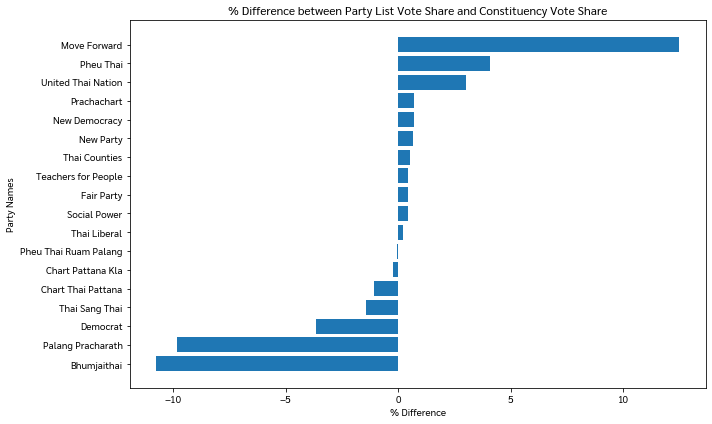

In [11]:
#### % Difference in vote share ####
filtered_data['difference'] =  filtered_data['% Party List Vote Share'] - filtered_data['% Constituency Vote Share']
filtered_data.sort_values(by='difference', ascending=True, inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(filtered_data['Party'], filtered_data['difference'])
plt.xlabel('% Difference')
plt.ylabel('Party Names')
plt.title('% Difference between Party List Vote Share and Constituency Vote Share')
plt.tight_layout()
plt.savefig("figures/diff_2023.jpg", dpi=300)

/Users/taozaze/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


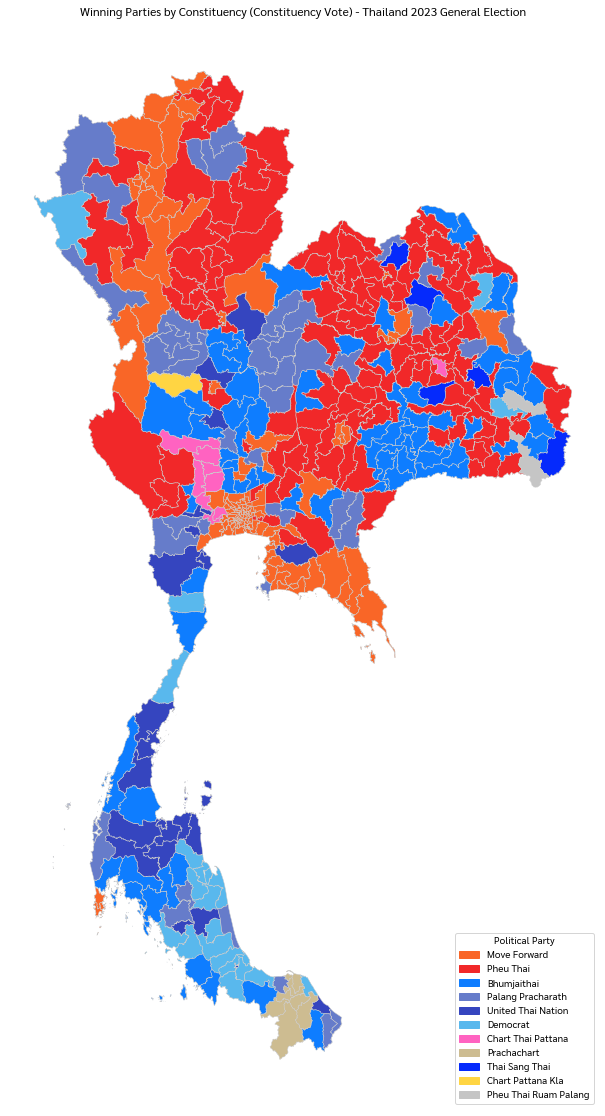

In [12]:
#### Mapping the election results (constituency vote) ####

# Merge the shapefile with the election results
merged_df = map_df.merge(constituency_winners, on=['จังหวัด', 'เขต'], how='outer', indicator=True)

# Define the color mapping
color_mapping = {
    'ก้าวไกล': '#F96627',
    'เพื่อไทย': '#F12829',
    'ภูมิใจไทย': '#0E7DFF',
    'พลังประชารัฐ': '#667CCA',
    'รวมไทยสร้างชาติ': '#3545BF',
    'ประชาธิปัตย์': '#59B8ED',
    'ชาติไทยพัฒนา': '#FF63C1',
    'ประชาชาติ': '#CDBC91',
    'ไทยสร้างไทย': '#052AFC',
    'ชาติพัฒนากล้า': '#FFD543',   
    'เพื่อไทรวมพลัง': '#C5C5C5'
}

# Define English party names for legend
english_mapping = {
    'ก้าวไกล': 'Move Forward',
    'เพื่อไทย': 'Pheu Thai',
    'ภูมิใจไทย': 'Bhumjaithai',
    'พลังประชารัฐ': 'Palang Pracharath',
    'รวมไทยสร้างชาติ': 'United Thai Nation',
    'ประชาธิปัตย์': 'Democrat',
    'ชาติไทยพัฒนา': 'Chart Thai Pattana',
    'ประชาชาติ': 'Prachachart',
    'ไทยสร้างไทย': 'Thai Sang Thai',
    'ชาติพัฒนากล้า': 'Chart Pattana Kla',   
    'เพื่อไทรวมพลัง': 'Pheu Thai Ruam Palang'
}

english_color_mapping = {english_mapping[key]: value for key, value in color_mapping.items()}

# Assign colors to the parties
merged_df['color'] = merged_df['พรรค'].map(color_mapping)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the election data
merged_df.plot(column='color', color=merged_df['color'], linewidth=0.5, edgecolor='0.8', legend=False, ax=ax)

# Customize and display the legend
legend_elements = [plt.Rectangle((0, 0), 1, 1, color=english_color_mapping[party], label=party) for party in english_color_mapping.keys()]
ax.legend(handles=legend_elements, title='Political Party', loc='lower right')
plt.title('Winning Parties by Constituency (Constituency Vote) - Thailand 2023 General Election')
ax.set_axis_off()

# Show the plot
plt.savefig("figures/constituency_vote.jpg", dpi=300)

/Users/taozaze/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


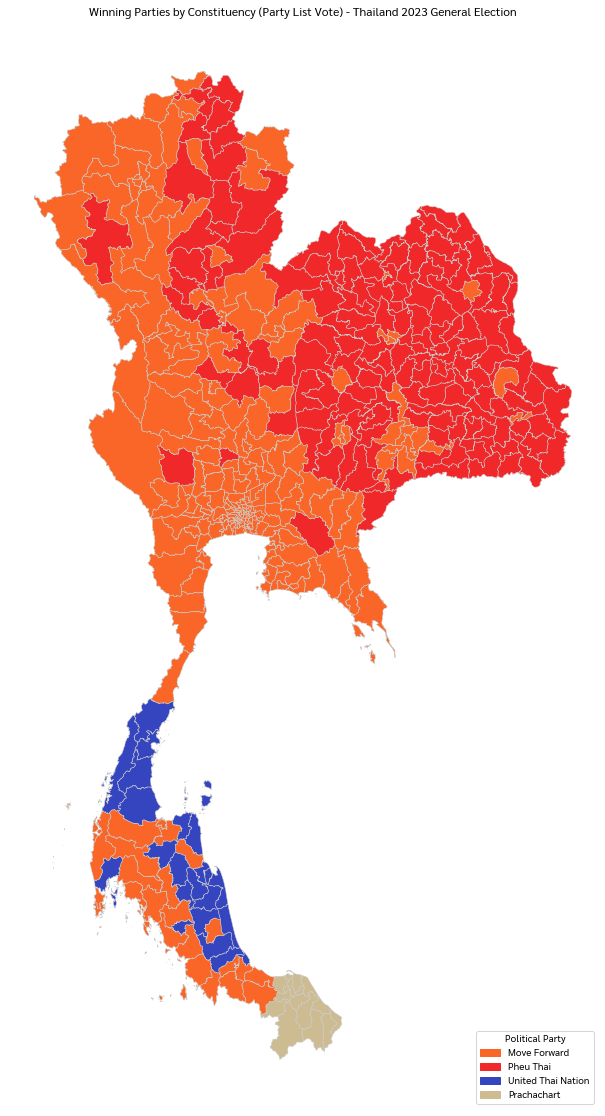

In [14]:
#### Mapping the election results (party list vote) ####

# Step 1: Find the index of the maximum vote count for each constituency
max_vote_indices = results_party_list.groupby(['จังหวัด', 'เขต'])['ผลคะแนน'].idxmax()

# Step 2: Create a new column and initialize it with zeros
results_party_list['winning_party'] = 0

# Step 3: Set the winning party to 1 for the corresponding indices
results_party_list.loc[max_vote_indices, 'winning_party'] = 1

# Filter the results to include only the winning parties
party_list_winners_by_cons = results_party_list[results_party_list['winning_party'] == 1]

# Merge the winning parties with the map data
merged_df = map_df.merge(party_list_winners_by_cons, on=['จังหวัด', 'เขต'], how='outer', indicator=True)

# Map Thai party names to English for legend
merged_df['party_in_english'] = merged_df['พรรค'].map(english_mapping)

# Assign colors to the parties
merged_df['color'] = merged_df['party_in_english'].map(english_color_mapping)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the election data
merged_df.plot(column='color', color=merged_df['color'], linewidth=0.5, edgecolor='0.8', legend=False, ax=ax)

# Find the unique parties that won in constituencies (in English)
winning_parties_in_english = merged_df[merged_df['winning_party'] == 1]['party_in_english'].unique()

# Customize and display the legend with English party names
legend_elements = [plt.Rectangle((0, 0), 1, 1, color=english_color_mapping[english_mapping[thai_name]], label=eng_name) 
                   for thai_name, eng_name in english_mapping.items() if eng_name in winning_parties_in_english]

ax.legend(handles=legend_elements, title='Political Party', loc='lower right')

plt.title('Winning Parties by Constituency (Party List Vote) - Thailand 2023 General Election')
ax.set_axis_off()

# Show the plot
plt.savefig("figures/party_list_vote.jpg", dpi=300)

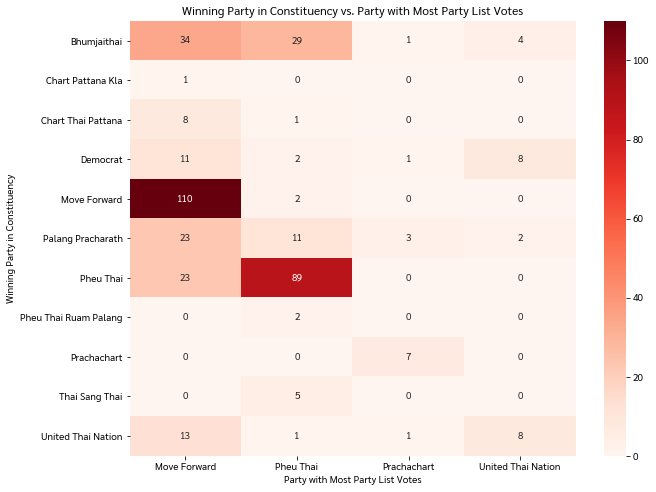

In [15]:
#### Generate a heatmap comparing party list winners and constituency winners ####
# Merge and Prepare Data
comparison_df = constituency_winners.merge(
    results_party_list[results_party_list['winning_party'] == 1], 
    on=['จังหวัด', 'เขต']
).rename(
    columns={'พรรค_x': 'ConstituencyWinner', 'พรรค_y': 'PartyListWinner'}
)[['จังหวัด', 'เขต', 'ConstituencyWinner', 'PartyListWinner']]

# Create a Dictionary for Name Translation
translation_dict = {
    'ก้าวไกล': 'Move Forward',
    'เพื่อไทย': 'Pheu Thai',
    'ภูมิใจไทย': 'Bhumjaithai',
    'พลังประชารัฐ': 'Palang Pracharath',
    'รวมไทยสร้างชาติ': 'United Thai Nation',
    'ประชาธิปัตย์': 'Democrat',
    'ชาติไทยพัฒนา': 'Chart Thai Pattana',
    'ประชาชาติ': 'Prachachart',
    'ไทยสร้างไทย': 'Thai Sang Thai',
    'ชาติพัฒนากล้า': 'Chart Pattana Kla',
    'เพื่อไทรวมพลัง': 'Pheu Thai Ruam Palang'
}

# Generate Frequency Table
frequency_table = pd.crosstab(
    index=comparison_df['ConstituencyWinner'].map(translation_dict), 
    columns=comparison_df['PartyListWinner'].map(translation_dict)
)

# Create and Display the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(frequency_table, cmap='Reds', annot=True, fmt='d')
plt.title('Winning Party in Constituency vs. Party with Most Party List Votes')
plt.xlabel('Party with Most Party List Votes')
plt.ylabel('Winning Party in Constituency')
plt.savefig("figures/heat_map.jpg", dpi=300)

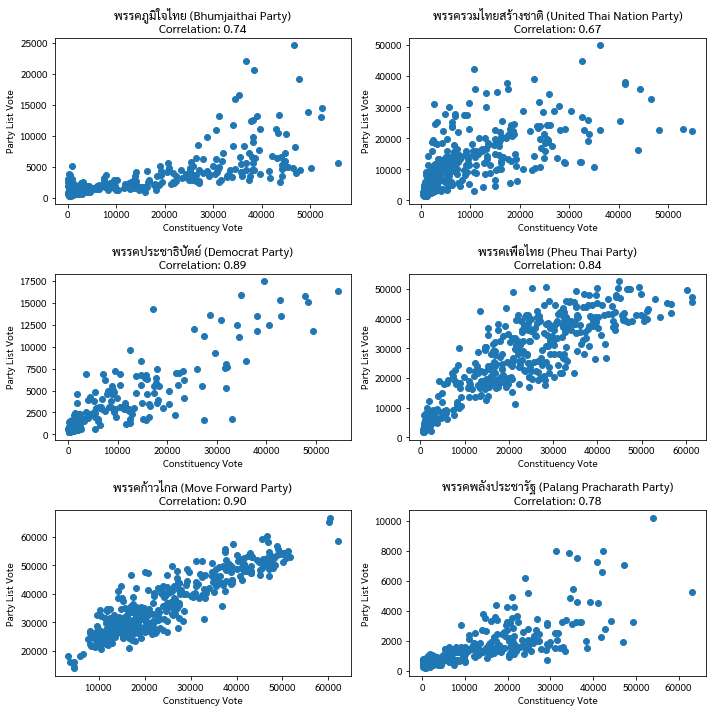

In [16]:
#### Facet plot comparing constituency vs party list votes for each party ####

# Data Preprocessing
results_candidate.rename(columns={'สังกัดพรรค': 'พรรค', 'คะแนน': 'constituency_vote'}, inplace=True)
results_party_list.rename(columns={'ผลคะแนน': 'party_list_vote'}, inplace=True)
merged_results = results_candidate.merge(results_party_list, on=['จังหวัด', 'เขต', 'พรรค'], how='right')

# Filter Data for Desired Parties
desired_party_names = ['ภูมิใจไทย', 'รวมไทยสร้างชาติ', 'ประชาธิปัตย์', 'เพื่อไทย', 'ก้าวไกล', 'พลังประชารัฐ']
results = merged_results[merged_results['พรรค'].isin(desired_party_names)]

# Set Up English Mapping for Party Names
english_mapping = {
    'ก้าวไกล': 'Move Forward',
    'เพื่อไทย': 'Pheu Thai',
    'ภูมิใจไทย': 'Bhumjaithai',
    'พลังประชารัฐ': 'Palang Pracharath',
    'รวมไทยสร้างชาติ': 'United Thai Nation',
    'ประชาธิปัตย์': 'Democrat',
    'ชาติไทยพัฒนา': 'Chart Thai Pattana',
    'ประชาชาติ': 'Prachachart',
    'ไทยสร้างไทย': 'Thai Sang Thai',
    'ชาติพัฒนากล้า': 'Chart Pattana Kla',   
    'เพื่อไทรวมพลัง': 'Pheu Thai Ruam Palang'
}

# Create Facet Plot
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    if i < len(desired_party_names):
        party_name = desired_party_names[i]
        party_data = merged_results[merged_results['พรรค'] == party_name]
        party_name_en = english_mapping[party_name]
        ax.scatter(party_data['constituency_vote'], party_data['party_list_vote'])
        ax.set_xlabel('Constituency Vote')
        ax.set_ylabel('Party List Vote')
        correlation = party_data['constituency_vote'].corr(party_data['party_list_vote'])
        ax.set_title(f"พรรค{party_name} ({party_name_en} Party)\nCorrelation: {correlation:.2f}")
        
plt.tight_layout()
plt.savefig("figures/constituency_party_list_scatter.jpg", dpi=300)

In [17]:
#### Check for the number of provinces in which MFP is in the top two (constituency vote) ####

# Step 1: Group by province and party name, then sum the votes that each party received in each province
constituency_votes_per_province = results_candidate.groupby(['จังหวัด', 'พรรค'])['constituency_vote'].sum().reset_index()

# Step 2: For each province, rank the parties based on the total votes they received. 
# Use the 'max' method to deal with ties by assigning the highest rank among the tied groups.
constituency_votes_per_province['vote_rank'] = constituency_votes_per_province.groupby('จังหวัด')['constituency_vote'].rank(method='max', ascending=False)

# Step 3: Filter this ranked DataFrame to include only those parties who came in first or second place in their province based on the votes.
first_and_second_place_constituency = constituency_votes_per_province[constituency_votes_per_province['vote_rank'].isin([1, 2])]

# Step 4: Define a function to check if 'Move Forward' is among the top two parties in each province.
def check_top_two(group):
    party_of_interest = 'ก้าวไกล'
    return party_of_interest in group['พรรค'].values

# Apply the function to each group (i.e., each province)
provinces_with_move_forward_in_top_two = first_and_second_place_constituency.groupby('จังหวัด').apply(check_top_two)

# Filter to get the provinces where 'Move Forward' is among the top two
provinces_with_move_forward_in_top_two = provinces_with_move_forward_in_top_two[provinces_with_move_forward_in_top_two]

# Step 5: Calculate the number and percentage of provinces where 'Move Forward' was among the top two parties

# Number of provinces where 'Move Forward' is among the top two
num_provinces_with_move_forward_in_top_two = len(provinces_with_move_forward_in_top_two)

# Total number of provinces
total_provinces = results_candidate['จังหวัด'].nunique()

# Percentage calculation
percentage_of_provinces_with_move_forward_in_top_two = (num_provinces_with_move_forward_in_top_two / total_provinces) * 100

# Print the result
print("Number of provinces where 'Move Forward' was among the top two:", num_provinces_with_move_forward_in_top_two)
print("Percentage of provinces where 'Move Forward' was among the top two:", percentage_of_provinces_with_move_forward_in_top_two, "%")


Number of provinces where 'Move Forward' was among the top two: 45
Percentage of provinces where 'Move Forward' was among the top two: 58.44155844155844 %


In [18]:
#### Check for the number of constituencies in which MFP is in the top two (constituency vote) ####

# Step 1: Group by constituency and party name, then sum the votes that each party received in each constituency
constituency_votes_per_constituency = results_candidate.groupby(['จังหวัด', 'เขต', 'พรรค'])['constituency_vote'].sum().reset_index()

# Step 2: For each constituency, rank the parties based on the total votes they received. 
# Use the 'max' method to deal with ties by assigning the highest rank among the tied groups.
constituency_votes_per_constituency['vote_rank'] = constituency_votes_per_constituency.groupby(['จังหวัด', 'เขต'])['constituency_vote'].rank(method='max', ascending=False)

# Step 3: Filter this ranked DataFrame to include only those parties who came in first or second place in their constituency based on the votes.
first_and_second_place_constituency = constituency_votes_per_constituency[constituency_votes_per_constituency['vote_rank'].isin([1, 2])]

# Step 4: Define a function to check if 'Move Forward' is among the top two parties in each constituency.
def check_top_two(group):
    party_of_interest = 'ก้าวไกล'
    return party_of_interest in group['พรรค'].values

# Apply the function to each group (i.e., each constituency)
constituencies_with_move_forward_in_top_two = first_and_second_place_constituency.groupby(['จังหวัด', 'เขต']).apply(check_top_two)

# Filter to get the constituencies where 'Move Forward' is among the top two
constituencies_with_move_forward_in_top_two = constituencies_with_move_forward_in_top_two[constituencies_with_move_forward_in_top_two]

# Step 5: Calculate the number and percentage of constituencies where 'Move Forward' was among the top two parties

# Number of constituencies where 'Move Forward' is among the top two
num_constituencies_with_move_forward_in_top_two = len(constituencies_with_move_forward_in_top_two)

# Total number of constituencies
total_constituencies = 400

# Percentage calculation
percentage_of_constituencies_with_move_forward_in_top_two = (num_constituencies_with_move_forward_in_top_two / total_constituencies) * 100

# Print the result
print("Number of constituencies where 'Move Forward' was among the top two:", num_constituencies_with_move_forward_in_top_two)
print("Percentage of constituencies where 'Move Forward' was among the top two:", percentage_of_constituencies_with_move_forward_in_top_two, "%")


Number of constituencies where 'Move Forward' was among the top two: 216
Percentage of constituencies where 'Move Forward' was among the top two: 54.0 %


In [19]:
#### Check for the number of provinces in which MFP is in the top two (party list vote) ####

# Step 1: Group by province and party name, then sum the votes that each party received in each province
constituency_votes_per_province = results_party_list.groupby(['จังหวัด', 'พรรค'])['party_list_vote'].sum().reset_index()

# Step 2: For each province, rank the parties based on the total votes they received. 
# Use the 'max' method to deal with ties by assigning the highest rank among the tied groups.
constituency_votes_per_province['vote_rank'] = constituency_votes_per_province.groupby('จังหวัด')['party_list_vote'].rank(method='max', ascending=False)

# Step 3: Filter this ranked DataFrame to include only those parties who came in first or second place in their province based on the votes.
first_and_second_place_constituency = constituency_votes_per_province[constituency_votes_per_province['vote_rank'].isin([1, 2])]

# Step 4: Define a function to check if 'Move Forward' is among the top two parties in each province.
def check_top_two(group):
    party_of_interest = 'ก้าวไกล'
    return party_of_interest in group['พรรค'].values

# Apply the function to each group (i.e., each province)
provinces_with_move_forward_in_top_two = first_and_second_place_constituency.groupby('จังหวัด').apply(check_top_two)

# Filter to get the provinces where 'Move Forward' is among the top two
provinces_with_move_forward_in_top_two = provinces_with_move_forward_in_top_two[provinces_with_move_forward_in_top_two]

# Step 5: Calculate the number and percentage of provinces where 'Move Forward' was among the top two parties

# Number of provinces where 'Move Forward' is among the top two
num_provinces_with_move_forward_in_top_two = len(provinces_with_move_forward_in_top_two)

# Total number of provinces
total_provinces = results_party_list['จังหวัด'].nunique()

# Percentage calculation
percentage_of_provinces_with_move_forward_in_top_two = (num_provinces_with_move_forward_in_top_two / total_provinces) * 100

# Print the result
print("Number of provinces where 'Move Forward' was among the top two:", num_provinces_with_move_forward_in_top_two)
print("Percentage of provinces where 'Move Forward' was among the top two:", percentage_of_provinces_with_move_forward_in_top_two, "%")


Number of provinces where 'Move Forward' was among the top two: 77
Percentage of provinces where 'Move Forward' was among the top two: 100.0 %


In [20]:
#### Check for the number of constituencies in which MFP is in the top two (party list vote) ####

# Step 1: Group by constituency and party name, then sum the votes that each party received in each constituency
constituency_votes_per_constituency = results_party_list.groupby(['จังหวัด', 'เขต', 'พรรค'])['party_list_vote'].sum().reset_index()

# Step 2: For each constituency, rank the parties based on the total votes they received. 
# Use the 'max' method to deal with ties by assigning the highest rank among the tied groups.
constituency_votes_per_constituency['vote_rank'] = constituency_votes_per_constituency.groupby(['จังหวัด', 'เขต'])['party_list_vote'].rank(method='max', ascending=False)

# Step 3: Filter this ranked DataFrame to include only those parties who came in first or second place in their constituency based on the votes.
first_and_second_place_constituency = constituency_votes_per_constituency[constituency_votes_per_constituency['vote_rank'].isin([1, 2])]

# Step 4: Define a function to check if 'Move Forward' is among the top two parties in each constituency.
def check_top_two(group):
    party_of_interest = 'ก้าวไกล'
    return party_of_interest in group['พรรค'].values

# Apply the function to each group (i.e., each constituency)
constituencies_with_move_forward_in_top_two = first_and_second_place_constituency.groupby(['จังหวัด', 'เขต']).apply(check_top_two)

# Filter to get the constituencies where 'Move Forward' is among the top two
constituencies_with_move_forward_in_top_two = constituencies_with_move_forward_in_top_two[constituencies_with_move_forward_in_top_two]

# Step 5: Calculate the number and percentage of constituencies where 'Move Forward' was among the top two parties

# Number of constituencies where 'Move Forward' is among the top two
num_constituencies_with_move_forward_in_top_two = len(constituencies_with_move_forward_in_top_two)

# Total number of constituencies
total_constituencies = 400

# Percentage calculation
percentage_of_constituencies_with_move_forward_in_top_two = (num_constituencies_with_move_forward_in_top_two / total_constituencies) * 100

# Print the result
print("Number of constituencies where 'Move Forward' was among the top two:", num_constituencies_with_move_forward_in_top_two)
print("Percentage of constituencies where 'Move Forward' was among the top two:", percentage_of_constituencies_with_move_forward_in_top_two, "%")


Number of constituencies where 'Move Forward' was among the top two: 400
Percentage of constituencies where 'Move Forward' was among the top two: 100.0 %


In [21]:
#### Compare vote share between regions ####

# Add Region
province_and_region = pd.read_excel('https://data.go.th/dataset/3aa027e3-5485-4da2-89b0-b399fab019a0/resource/0c2aa4d6-90ef-405f-acf2-20507ced4fab/download/25640531_sc002_.xlsx') # Link: https://data.go.th/dataset/proviceandregionthailand
province_and_region['จังหวัด'] = province_and_region['ProvinceNameThai'].str.replace('จังหวัด', '')
province_and_region['province_id'] = province_and_region['ProvinceMOI_ID']

results_candidate = results_candidate.merge(province_and_region[['จังหวัด','province_id', 'RegionECT', 'Region_SenatorFieldWork']], on = 'จังหวัด', how = 'left')
results_party_list = results_party_list.merge(province_and_region[['จังหวัด','province_id', 'RegionECT', 'Region_SenatorFieldWork']], on = 'จังหวัด', how = 'left')

# Define Bangkok and assign to region
results_candidate['is_bangkok'] = (results_candidate['จังหวัด'] == 'กรุงเทพมหานคร').astype(int)
results_candidate.loc[results_candidate['is_bangkok'] == 1, 'RegionECT'] = 'กรุงเทพมหานคร'

results_party_list['is_bangkok'] = (results_party_list['จังหวัด'] == 'กรุงเทพมหานคร').astype(int)
results_party_list.loc[results_party_list['is_bangkok'] == 1, 'RegionECT'] = 'กรุงเทพมหานคร'

# Calculate the percentage of constituency votes for each party in each region
party_preferences_con = results_candidate.groupby(['RegionECT', 'พรรค'])['constituency_vote'].sum().reset_index()
party_preferences_con['percent_votes'] = party_preferences_con.groupby('RegionECT')['constituency_vote'].apply(lambda x: x / x.sum() * 100)

# Calculate the percentage of party list votes for each party in each region
party_preferences_pl = results_party_list.groupby(['RegionECT', 'พรรค'])['party_list_vote'].sum().reset_index()
party_preferences_pl['percent_votes'] = party_preferences_pl.groupby('RegionECT')['party_list_vote'].apply(lambda x: x / x.sum() * 100)

In [22]:
# Filter by parties
party_names = ['ก้าวไกล', 'เพื่อไทย', 'ภูมิใจไทย', 'พลังประชารัฐ', 'รวมไทยสร้างชาติ', 'ประชาธิปัตย์']
party_preferences_con = party_preferences_con[party_preferences_con['พรรค'].isin(party_names)].copy()
party_preferences_pl = party_preferences_pl[party_preferences_pl['พรรค'].isin(party_names)].copy()

# Merge
party_preferences = party_preferences_con.merge(party_preferences_pl, on = ['RegionECT', 'พรรค'])

# Define color mapping for political parties
color_mapping = {
    'ก้าวไกล': '#F96627',
    'เพื่อไทย': '#F12829',
    'ภูมิใจไทย': '#0E7DFF',
    'พลังประชารัฐ': '#667CCA',
    'รวมไทยสร้างชาติ': '#3545BF',
    'ประชาธิปัตย์': '#59B8ED',
    'ชาติไทยพัฒนา': '#FF63C1',
    'ประชาชาติ': '#CDBC91',
    'ไทยสร้างไทย': '#052AFC',
    'ชาติพัฒนากล้า': '#FFD543',   
    'เพื่อไทรวมพลัง': '#C5C5C5'
}

# Define English party names
english_mapping = {
    'ก้าวไกล': 'Move Forward',
    'เพื่อไทย': 'Pheu Thai',
    'ภูมิใจไทย': 'Bhumjaithai',
    'พลังประชารัฐ': 'Palang Pracharath',
    'รวมไทยสร้างชาติ': 'United Thai Nation',
    'ประชาธิปัตย์': 'Democrat',
    'ชาติไทยพัฒนา': 'Chart Thai Pattana',
    'ประชาชาติ': 'Prachachart',
    'ไทยสร้างไทย': 'Thai Sang Thai',
    'ชาติพัฒนากล้า': 'Chart Pattana Kla',   
    'เพื่อไทรวมพลัง': 'Pheu Thai Ruam Palang'
}

# Define Region Names
region_mapping = {
    'กรุงเทพมหานคร': 'Bangkok',
    'ภาคกลาง': 'Central',
    'ภาคตะวันออกเฉียงเหนือ': 'Northeast',
    'ภาคเหนือ': 'North',
    'ภาคใต้': 'South',
}

party_preferences['พรรค'] = party_preferences['พรรค'].replace(english_mapping)
party_preferences['RegionECT'] = party_preferences['RegionECT'].replace(region_mapping)


english_color_mapping = {english_mapping[key]: value for key, value in color_mapping.items()}

In [23]:
#### Bar plot comparing constituency vote share by party by region ####

plt.figure(figsize=(15, 6))
sns.barplot(x='RegionECT', y='percent_votes_x', hue='พรรค', data=party_preferences, palette=english_color_mapping)
plt.title('Party Preferences Across Regions in Thailand (Constituency)', fontsize=18)
plt.xlabel('Region', fontsize=18)
plt.ylabel('Percent Vote Share', fontsize=18)
plt.yticks(fontsize= 14)
plt.xticks(rotation=0, fontsize= 14)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize = 14)
plt.tight_layout()
plt.savefig("figures/Party_Preferences_Across_Regions (Constituency).jpg", dpi=300)
plt.show()

#### Bar plot comparing party list vote share by party by region ####

plt.figure(figsize=(15, 6))
sns.barplot(x='RegionECT', y='percent_votes_y', hue='พรรค', data=party_preferences, palette=english_color_mapping)
plt.title('Party Preferences Across Regions in Thailand (Party List)', fontsize=18)
plt.xlabel('Region', fontsize=18)
plt.ylabel('Percent Vote Share', fontsize=18)
plt.yticks(fontsize= 14)
plt.xticks(rotation=0, fontsize= 14)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize = 14)
plt.tight_layout()
plt.savefig("figures/Party_Preferences_Across_Regions (Party List).jpg", dpi=300)
plt.show()

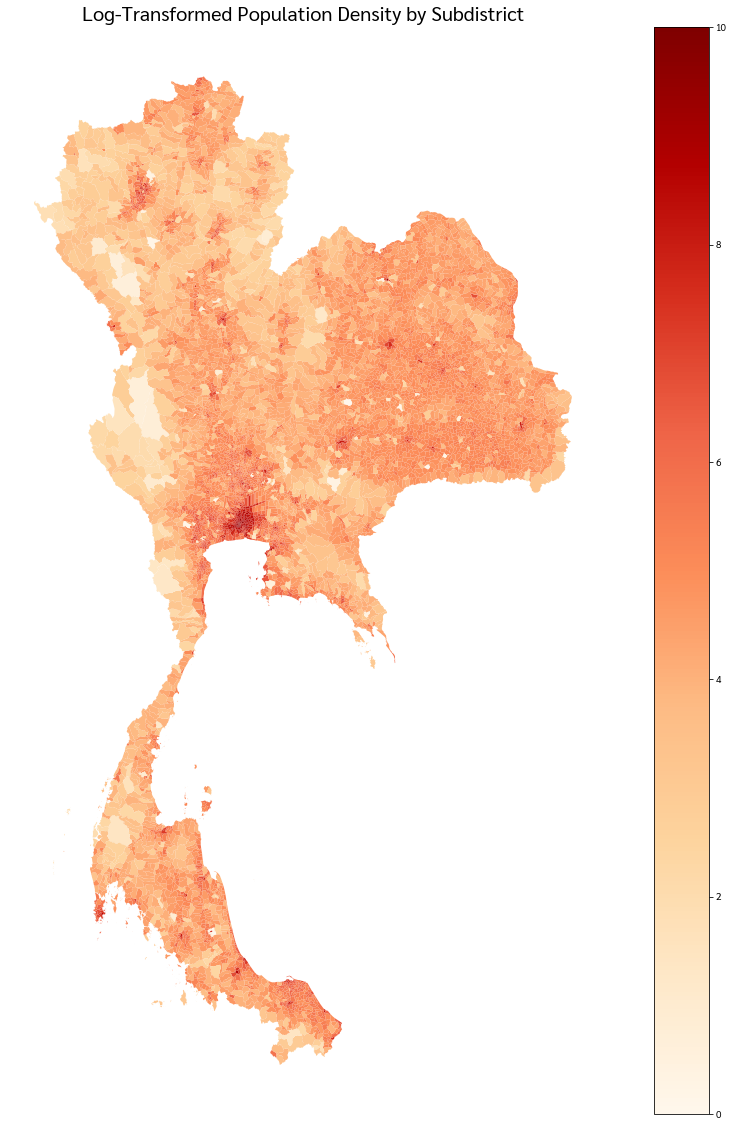

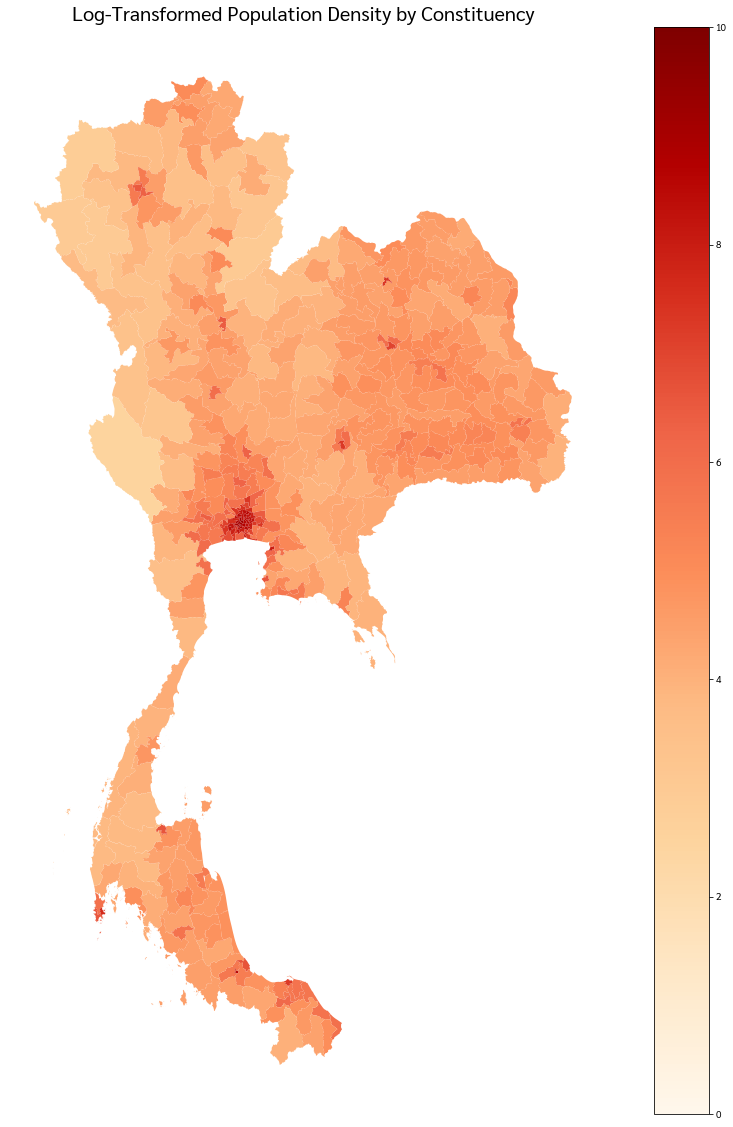

In [24]:
#### Population Density Analysis ####

### Tambon level ###

# Load the shapefile with the 'TIS620' encoding
import geopandas as gpd
gdf = gpd.read_file("shapefiles/tambon_with_pop.shp", encoding='TIS620')

# Calculate Area in square kilometers
gdf['Area_km2'] = gdf['geometry'].to_crs(epsg=3395).area / 10**6

# Prepare Population Data
gdf['Population'] = gdf['thai_pop_8']


# Calculate Population Density
gdf['Population_Density'] = gdf['Population'] / gdf['Area_km2']

# Log Transformation of Population Density
gdf['Log_Population_Density'] = gdf['Population_Density'].apply(lambda x: 0 if x == 0 else (np.log(x + 1)))

# Plot Choropleth Map with Continuous Log-Transformed Population Density
continuous_map = gdf.plot(column='Log_Population_Density', cmap='OrRd', legend=True, figsize=(20, 20), vmin = 0, vmax = 10)
continuous_map.set_title('Log-Transformed Population Density by Subdistrict', fontsize=20)
continuous_map.set_xlabel('Longitude')
continuous_map.set_ylabel('Latitude')
plt.axis('off')
plt.savefig('figures/Continuous Log-Transformed Population Density_tambon.jpg', dpi=300)


### Constituency level ###
gdf = gpd.read_file("shapefiles/constituency_density.shp", encoding='TIS620')

# Calculate Area in square kilometers
gdf['Area_km2'] = gdf['geometry'].to_crs(epsg=3395).area / 10**6

# Prepare Population Data
gdf['Population'] = gdf['thai_pop_จ']

# Calculate Population Density
gdf['Population_Density'] = gdf['Population'] / gdf['Area_km2']

# Log Transformation of Population Density
gdf['Log_Population_Density'] = gdf['Population_Density'].apply(lambda x: 0 if x == 0 else (np.log(x + 1)))

# Plot Choropleth Map with Continuous Log-Transformed Population Density

continuous_map = gdf.plot(column='Log_Population_Density', cmap='OrRd', legend=True, figsize=(20, 20), vmin = 0, vmax = 10)
continuous_map.set_title('Log-Transformed Population Density by Constituency', fontsize=20)
continuous_map.set_xlabel('Longitude')
continuous_map.set_ylabel('Latitude')
plt.axis('off')
plt.savefig("figures/Continuous Log-Transformed Population Density_constituency.jpg", dpi=300)


In [25]:
#### Find the correlation between population density and constituency vote share ####

# Calculate the total votes for each constituency in constituency results
results_candidate['total_constituency_vote'] = results_candidate.groupby(['จังหวัด', 'เขต'])['constituency_vote'].transform('sum')

# Calculate vote share for each candidate
results_candidate['percent_vote_share'] = (results_candidate['constituency_vote'] / results_candidate['total_constituency_vote']) * 100

# Calculate the total party-list votes for each constituency in party list results
results_party_list['total_party_list_vote'] = results_party_list.groupby(['จังหวัด', 'เขต'])['party_list_vote'].transform('sum')

# Calculate vote share for each party
results_party_list['percent_vote_share'] = (results_party_list['party_list_vote'] / results_party_list['total_party_list_vote']) * 100

# Merge with population density
gdf.rename(columns={'P_name':'จังหวัด', 'CONS_no':'เขต'}, inplace=True)
merged_df = gdf.merge(results_candidate, on=['จังหวัด', 'เขต'], how='outer', indicator=True)

# Filter for parties
party_names = ['ก้าวไกล', 'เพื่อไทย', 'ภูมิใจไทย', 'พลังประชารัฐ', 'รวมไทยสร้างชาติ', 'ประชาธิปัตย์']
merged_df = merged_df[merged_df['พรรค'].isin(party_names)].copy()

# Define English party names
english_mapping = {
    'ก้าวไกล': 'Move Forward',
    'เพื่อไทย': 'Pheu Thai',
    'ภูมิใจไทย': 'Bhumjaithai',
    'พลังประชารัฐ': 'Palang Pracharath',
    'รวมไทยสร้างชาติ': 'United Thai Nation',
    'ประชาธิปัตย์': 'Democrat',
    'ชาติไทยพัฒนา': 'Chart Thai Pattana',
    'ประชาชาติ': 'Prachachart',
    'ไทยสร้างไทย': 'Thai Sang Thai',
    'ชาติพัฒนากล้า': 'Chart Pattana Kla',   
    'เพื่อไทรวมพลัง': 'Pheu Thai Ruam Palang'
}

# Assign English names
merged_df['พรรค'] = merged_df['พรรค'].replace(english_mapping)

<Figure size 2160x2160 with 0 Axes>

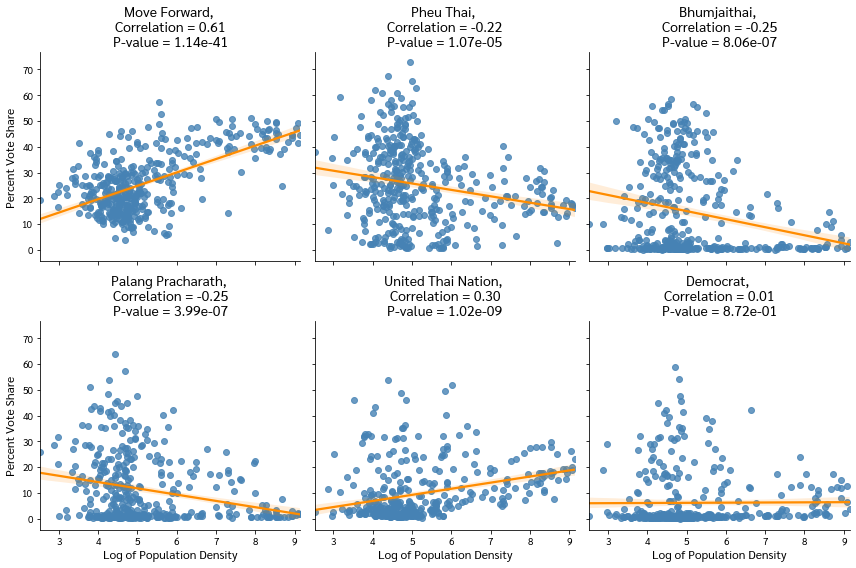

In [26]:
#### Create facet plot ####

from scipy import stats
party_order = ['Move Forward', 'Pheu Thai', 'Bhumjaithai', 'Palang Pracharath', 'United Thai Nation', 'Democrat']

# Increase the size of the plot
plt.figure(figsize=(30, 30))

# Create the FacetGrid
g = sns.FacetGrid(merged_df, col="พรรค", col_wrap=3, height=4, aspect=1, col_order=party_order)

# Map the scatter plot and regression line to the grid
g = g.map(sns.regplot, 'Log_Population_Density', 'percent_vote_share', color="steelblue", fit_reg=False)
g = g.map(sns.regplot, 'Log_Population_Density', 'percent_vote_share', scatter=False, color="darkorange")

# Set the titles and labels
g = g.set_titles("{col_name}", size=14)
g = g.set_xlabels("Log of Population Density", size=12)
g = g.set_ylabels("Percent Vote Share", size=12)

# Calculate and annotate the correlation coefficient and p-value
for ax in g.axes.flat:
    # Get the current party number
    party_name = ax.title.get_text()
    
    # Get the data for the current party
    party_data = merged_df[merged_df['พรรค'] == party_name]
    
    # Calculate the correlation coefficient and the p-value
    corr_coef, p_value = stats.pearsonr(party_data['Log_Population_Density'], party_data['percent_vote_share'])

    # Set the title to the party name, correlation coefficient and p-value
    ax.set_title(f'{party_name}, \nCorrelation = {corr_coef:.2f}\nP-value = {p_value:.2e}', fontsize=14)

plt.tight_layout()
plt.savefig("figures/vote_share_and_density_corr.jpg", dpi=300)